In [2]:
# https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus?select=restaurant-menus.csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import Checkbox

from sklearn.impute import SimpleImputer
from ipywidgets import widgets
import os
from IPython.display import clear_output


In [32]:
# The function converts the list of restaurant categories into separate columns of data
def Processing_category(df):

    # I reduce the names of restaurant categories to lowercase letters, and separate them into new columns with names from 0 - 29
    df=df.join(df['category'].str.lower().str.split(',', expand=True))

    df.drop('category', axis=1, inplace=True)

#I create columns for each separate restaurant category
    df_cat_rest=pd.get_dummies(df, drop_first = False, columns= [x for x in range(0,30)], prefix_sep='', prefix='' )


#Sums up categories that duplicate each other. The names of the categories are in columns numbered from 8
    df_sum_cat = df_cat_rest.iloc[:,8:].groupby(df_cat_rest.columns[8:], axis=1).sum()
    df_new_rest=df_cat_rest.iloc[:,:8].join(df_sum_cat)
    return df_new_rest

# function returns the filtered table
def filter_restaurants(df, prices=[0,1,2,3,4], score_min=0, position_max=1000):

    con1=df['position']<=position_max 
    con2=df['score']>=score_min 
    con3= df['price'].isin(prices)
    return df[ con1 & con2 & con3]


# collapsing two restaurant categories into one
def reduce_cat(df_cat, oldName, oriName):

    try:
        df_cat.loc[oriName,'sum']=df_cat.loc[oldName, 'sum'] + df_cat.loc[oriName, 'sum']
        df_cat.drop([oldName], axis=0, inplace=True)
    except:
        pass
    return df_cat

# Function which create table with summarizing category of restaurants
def create_cat_table(df_sum_cat):

    df_new_sum =df_sum_cat.sum(axis=0).reset_index()
    df_new_sum.columns=['category', 'sum']
    df_cat=df_new_sum.sort_values('sum', ascending= False).set_index('category')
    df_cat.drop(df_cat[df_cat['sum']<1].index, inplace= True)

    reducedNames = { ' sandwiches': ' sandwich', ' family meals': ' family friendly', ' personal care': ' home &amp; personal care', 'steak': ' steak', 'pizza': ' pizza', 'italian': ' italian' , 'everyday essentials': ' everyday essentials' }
    for newN, oldN in reducedNames.items():
        df_cat = reduce_cat(df_cat, oldN, newN)

    try:
        df_cat.drop('american', axis=0, inplace=True)
 
    except:
        pass
    df_cat = df_cat.iloc[:20,:].sort_values('sum', ascending= False)
    df_cat['percent (%)']= df_cat['sum']/ df_cat['sum'].sum()* 100
    df_cat['percent (%)'] = np.around(df_cat['percent (%)'], decimals=1)
    return df_cat


# Removal of unnecessary address data, labeling of price data
def Preprocessing_df_restaurants(df_restaurant):

    df_restaurant = df_restaurant.drop(['full_address', 'zip_code'], axis=1)
    df_restaurant['price'] = df_restaurant["price_range"].map({None : 0, "$" : 1, "$$" : 2,"$$$" : 3, "$$$$" : 4})
    df_restaurant = df_restaurant.drop(['price_range'], axis=1)


def Handling_missing_values_restaurant(df_restaurant):

    df_missing_restaurant = df_restaurant.copy()
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')

    df_missing_restaurant['price'] = median_imputer.fit_transform(df_missing_restaurant['price'].values.reshape(-1,1))
    df_missing_restaurant['score'] = mean_imputer.fit_transform(df_missing_restaurant['score'].values.reshape(-1,1))

    return df_missing_restaurant


In [4]:
df_menu=pd.read_csv('restauracje/restaurant-menus.csv')

df_restaurant=pd.read_csv('restauracje/restaurants.csv')

df_restaurant=Preprocessing_df_restaurants(df_restaurant)


In [34]:
df_processed_category=Processing_category(df_restaurant)

df_full =Handling_missing_values_restaurant(df_processed_category)



Shows a list of N_restaurants most popular restaurants in a group filtered on the basis of the widget and filtered on the basis of price, ranking and position in the search engine

In [69]:
N_restaurants = 6

def changed(b):
    clear_output()
    display(container, alignment=False)
    display(container2, alignment=False)
    df_filtered= filter_restaurants(df_full, position_max=max_pos.value, prices =[ i for i, value in enumerate([boxP0.value, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True], score_min=min_score.value)

#Lists the best restaurants (top 10) sorted by position descending, score ascending, ratings ascending
    df_sorted=df_filtered.sort_values(['position', 'score', 'ratings'], ascending= [True, False, False]).head(N_restaurants)
    display(df_sorted)

###RangeSlider
min_score = widgets.FloatSlider(
    value=2.0,
    min=1.0,
    max=5.0,
    step=0.1,
    description='Minimalna ocena:',
    continuous_update=False
)
max_pos = widgets.IntSlider(
    value=3,
    min=1.0,
    max=100,
    step=1.0,
    description='Maksymalna pozycja w wyszukiwarce:',
    continuous_update=False
)

boxP0 = Checkbox(False, description='Price 0')
boxP1= Checkbox(False, description='Price 1')
boxP2 = Checkbox(False, description='Price 2')
boxP3 = Checkbox(False, description='Price 3')
boxP4 = Checkbox(False, description='Price 4')
container = widgets.HBox(children=[boxP0, boxP1, boxP2, boxP3,boxP4 ])
container2 = widgets.HBox(children=[min_score, max_pos ])


boxP0.observe(changed,names="value")
boxP1.observe(changed,names="value")
boxP2.observe(changed,names="value")
boxP3.observe(changed,names="value")
boxP4.observe(changed,names="value")
max_pos.observe(changed,names="value")
min_score.observe(changed,names="value")

display(container, alignment=False)
display(container2, alignment=False)



,id,position,name,score,ratings,lat,lng,price,aapi-owned,adult,...,vegetarian / vegan,vegetarian friendly,vegetarian-friendly,venezuelan,vietnamese,western,western-style japanese food,wine,wings,women-owned
9416,9417,1,Pressed Acai Bowls - Totem Lake,5.0,13.0,47.712890,-122.178460,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
38987,38988,1,Vitality Bowls (2750 E Southlake Blvd Suite 110),4.9,118.0,32.939129,-97.108640,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
26783,26784,1,Corned Beef King (Rockville),4.9,46.0,39.089476,-77.149007,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
27425,27426,1,Scratch Bakery - Hampton,4.9,18.0,37.018213,-76.321559,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
37472,37473,1,Whataburger (103 E Hwy 80),4.9,14.0,32.520990,-94.860660,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7524,7525,1,Happy Teriyaki (Lacey),4.8,200.0,47.055386,-122.766338,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0


It shows the chart and N_category tables of the most popular restaurant categories in the group filtered on the basis of the widget

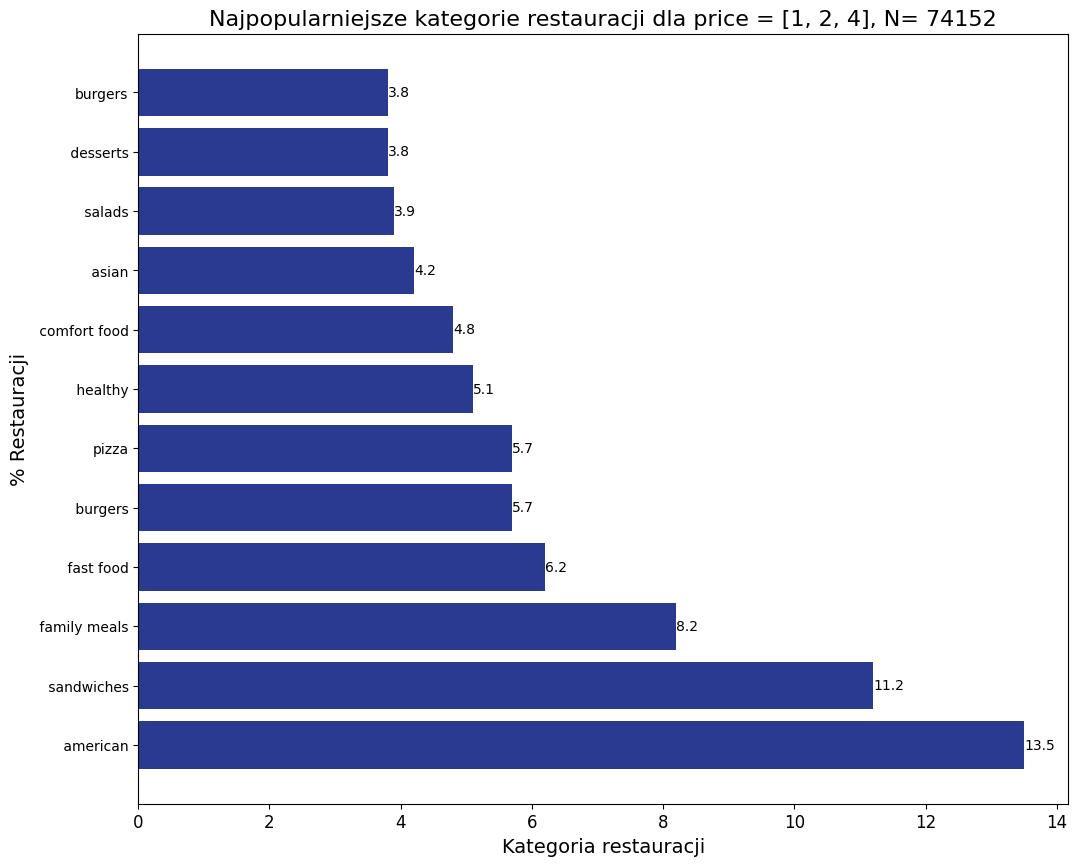

 Ilosc restauracji: 74152


,sum,percent (%)
category,,
american,9976,13.5
sandwiches,8308,11.2
family meals,6095,8.2
fast food,4604,6.2
burgers,4220,5.7
pizza,4219,5.7
healthy,3749,5.1
comfort food,3552,4.8
asian,3131,4.2


In [ ]:
N_category=12 


boxP1= Checkbox(False, description='Price 1')
boxP2 = Checkbox(False, description='Price 2')
boxP3 = Checkbox(False, description='Price 3')
boxP4 = Checkbox(False, description='Price 4')

###RangeSlider
min_score = widgets.FloatSlider(
    value=1.0,
    min=1.0,
    max=5.0,
    step=0.1,
    description='Min. rate:',
    continuous_update=False
)
max_pos = widgets.IntSlider(
    value=300,
    min=1.0,
    max=300,
    step=1.0,
    description='Max pos:',
    continuous_update=False
)

plt.style.use('default')
container = widgets.HBox(children=[boxP1, boxP2, boxP3,boxP4 ])
container2 = widgets.HBox(children=[min_score, max_pos ])
display(container, alignment=False)
display(container2, alignment=False)


def changed(b):
    clear_output()
    display(container, alignment=False)
    display(container2, alignment=False)
    df_filtered= filter_restaurants(df_full, position_max=max_pos.value, prices =[ i for i, value in enumerate([0, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True], score_min=min_score.value)
    cat_table =create_cat_table(df_filtered.iloc[:,12:])


    prices = [ i for i, value in enumerate([False, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True]

    
    fig, ax = plt.subplots()
    bars = ax.barh(cat_table.iloc[:N_category, -1].index, cat_table.iloc[:N_category, -1].values, color=(41/255, 58/255, 144/255))

    ax.bar_label(bars)
    plt.rcParams["figure.figsize"] = (12,10)
    N=cat_table['sum'].sum()
    ax.set_xlabel('Kategoria restauracji', fontsize=14)
    ax.set_ylabel('% Restauracji', fontsize=14)
    ax.set_title(f'Najpopularniejsze kategorie restauracji dla price = {prices}, N= {N}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.show()
    print(f" Ilosc restauracji: {cat_table['sum'].sum()}")
    display(cat_table.head(10))

boxP1.observe(changed,names="value")
boxP2.observe(changed,names="value")
boxP3.observe(changed,names="value")
boxP4.observe(changed,names="value")
max_pos.observe(changed,names="value")
min_score.observe(changed,names="value")


